# Procedural Python for Reproducibility

The goal today is to take some of the ideas we developed last week, and do a couple things to make our lives easier:

- Define standalone functions which accomplish tasks that we would like to do repeatedly
- Put these functions in a place where we can easily use them without copy-pasting repeatedly
- Think about how to make our analysis reproducible – both for the sake of our future selves, and for the sake of anyone who wants to replicate and/or build on our work.

To that end, we are going to work together to do the following tasks:

1. Write a function which will download the Pronto data and the weather data

   - This function should **only** download the data if it isn't already present on disk
   - Pronto trip data can be downloaded at https://data.seattle.gov/api/views/tw7j-dfaw/rows.csv?accessType=DOWNLOAD
   - Seattle weather data can be downloaded at http://uwseds.github.io/data/pronto_weather.csv
   
2. Write two functions which, given the downloaded data, will load it, parse dates properly, and return a pandas array.
   
3. Write a function which will group and join the trip and weather data into a single DataFrame, making use of the above functions.
   
4. Develop some plots showing relationships in the data, and write a function which will create and save plots related to your analysis.

   - Number of rides per day over the course of the year (short-term vs annual members)
   - Number of rides per hour over the course of the day (short-term vs annual members)
   - Number of rides per day as a function of temperature (short-term vs annual members)
   
5. Write a master script that you – or anyone – can run, which will produce your analysis from scratch.

Today during the class time we will walk through accomplishing these tasks together.

---

When we are finished, we'll have something like this:

In [1]:
# file: pronto_utils.py

from urllib.request import urlretrieve
import os

import pandas as pd
import matplotlib.pyplot as plt

WEATHER_URL = 'http://uwseds.github.io/data/pronto_weather.csv'
WEATHER_FILE = 'pronto_weather.csv'

PRONTO_URL = 'https://data.seattle.gov/api/views/tw7j-dfaw/rows.csv?accessType=DOWNLOAD'
PRONTO_FILE = 'pronto_trips.csv'


def get_weather_data():
    if not os.path.exists(WEATHER_FILE):
        print("downloading", WEATHER_URL)
        urlretrieve(WEATHER_URL, WEATHER_FILE)
    else:
        print(WEATHER_FILE, "already downloaded")
    return pd.read_csv(WEATHER_FILE, parse_dates=['DATE'], index_col='DATE')


def get_pronto_data():
    if not os.path.exists(PRONTO_FILE):
        print("downloading", PRONTO_URL)
        urlretrieve(PRONTO_URL, PRONTO_FILE)
    else:
        print(PRONTO_FILE, "already downloaded")
    data = pd.read_csv(PRONTO_FILE)
    data['starttime'] = pd.to_datetime(data['starttime'], format='%m/%d/%Y %I:%M:%S %p')
    data['stoptime'] = pd.to_datetime(data['stoptime'], format='%m/%d/%Y %I:%M:%S %p')
    return data


def get_trips_and_weather():
    weather_data = get_weather_data()
    pronto_data = get_pronto_data()

    date = pd.DatetimeIndex(pronto_data['starttime']).date
    trips_by_date = pronto_data.pivot_table('trip_id',
                                            index=date,
                                            columns='usertype',
                                            aggfunc='count')
    return trips_by_date.join(weather_data)


def plot_daily_totals():
    plt.style.use('seaborn')

    data = get_pronto_data()
    date = pd.DatetimeIndex(data.starttime).date
    trips_by_date = data.pivot_table('trip_id',
                                     index=date,
                                     columns='usertype',
                                     aggfunc='count')
    trips_by_date.plot(figsize=(16, 6))
    plt.ylabel('rides per day')
    plt.savefig('daily_totals.png')
    

def plot_hourly_totals():
    plt.style.use('seaborn')

    data = get_pronto_data()
    hour = pd.DatetimeIndex(data.starttime).hour
    trips_by_hour = data.pivot_table('trip_id',
                                     index=hour,
                                     columns='usertype',
                                     aggfunc='count')
    trips_by_hour.plot()
    plt.ylabel('rides per hour')
    plt.savefig('hourly_totals.png')
    
    
def plot_trips_by_temperature():
    plt.style.use('seaborn')
    data = get_trips_and_weather()
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    data.plot.scatter('AVG_TEMPERATURE_F', 'Member', ax=ax[0], color='blue', alpha=0.4)
    ax[0].set_title('Annual Members')
    ax[0].set_ylabel('Daily total rides')

    data.plot.scatter('AVG_TEMPERATURE_F', 'Short-Term Pass Holder', ax=ax[1], color='green', alpha=0.4)
    ax[1].set_title('Day Pass Users')
    fig.savefig('temperature_trend.png')

---

With this file created, we can import the code and re-create the figures in the notebook:

In [2]:
%matplotlib inline
import pronto_utils

pronto_trips.csv already downloaded


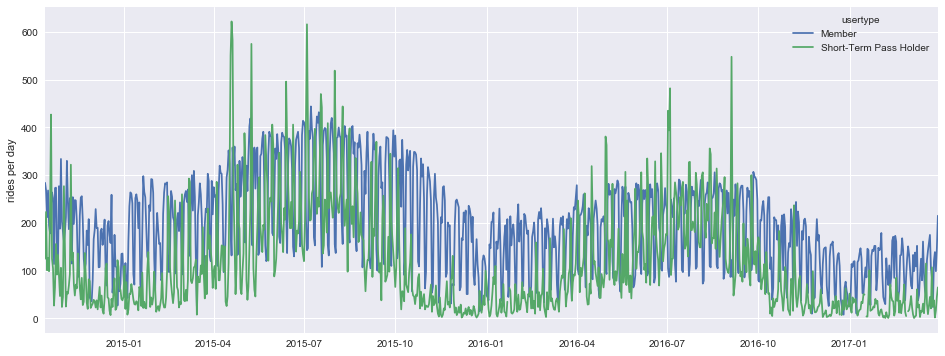

In [3]:
pronto_utils.plot_daily_totals()

pronto_trips.csv already downloaded


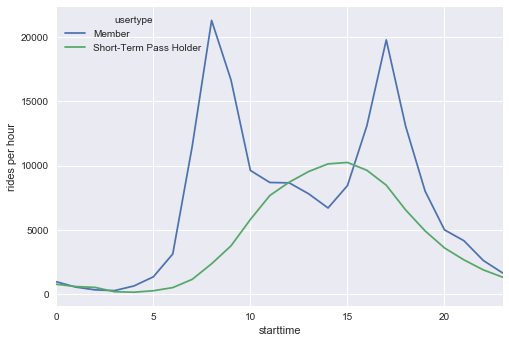

In [4]:
pronto_utils.plot_hourly_totals()

pronto_weather.csv already downloaded
pronto_trips.csv already downloaded


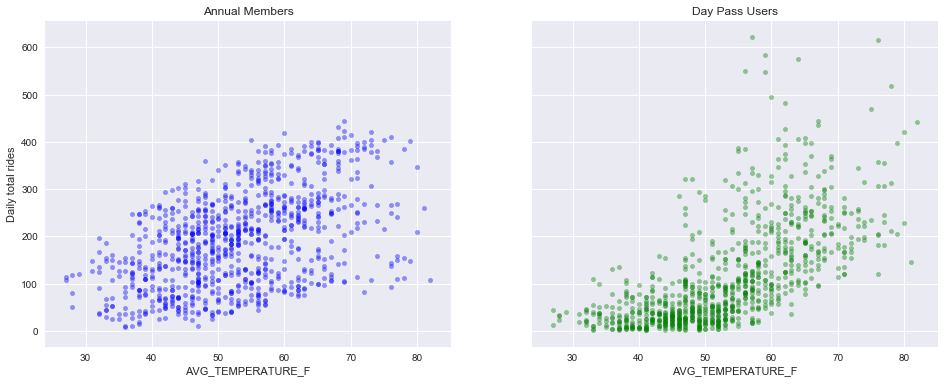

In [5]:
pronto_utils.plot_trips_by_temperature()